<a href="https://colab.research.google.com/github/ekremcet/CoinDetection/blob/master/CoinDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing the Collab


**Install Required Libraries**

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

    100% |████████████████████████████████| 5.7MB 7.9MB/s 
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1
  [PIL]
You must restart the runtime in order to use newly installed versions.


**Import the Data into Collab**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Initializing and Training Model

**Imports**

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

**Data Paths and Constants**

In [0]:
TRAIN_DIR = '/content/drive/My Drive/TrainData'
TEST_DIR = '/content/drive/My Drive/TestData'
IMG_SIZE = 256

**Helper Function to Load Data**

In [0]:
def load_data(data_dir):
    data_transforms = transforms.Compose([transforms.Resize(IMG_SIZE), transforms.ToTensor(), ]) # Define the transform: Resize the image and convert to Tensor
    data_folder = datasets.ImageFolder(data_dir, transform=data_transforms) 

    num_train = len(data_folder)
    indices = list(range(num_train))
    np.random.shuffle(indices) # Randomly select samples at each batch
    sampler = SubsetRandomSampler(indices)
    data = torch.utils.data.DataLoader(data_folder, sampler=sampler, batch_size=64) # Define a data loader, 64 images will be fed to network at each step

    return data

**Define the Network**


In [0]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Conv -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), 16 * 61 * 61) # This flattens the output (16, 61, 61) -> 59536
        x = F.relu(self.fc1(x)) # Fully Connected Layer -> ReLU
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model = ConvNet()
print(model)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


## Convolution
Conv2d(3, 6, 5) means that the input will have 3 channels, there will be 6 output channels and 5x5 kernel will be applied to image. <br>
![Convolution](https://upload.wikimedia.org/wikipedia/commons/4/4f/3D_Convolution_Animation.gif)

*Visual is taken from https://wikimedia.org/wikipedia/commons/4/4f/3D_Convolution_Animation.gif*

---


<br>
## Model Architecture:
![Model](https://gistcdn.githack.com/ekremcet/ed14ecca79c3d03539f6f3c9a4156334/raw/0ed3ae10cffadc589e13bfa60a68a6c1ed6c58ac/coinnet.svg  =840x)



---
## Activation Function
After each convolution we need some non-linearity and we impose that with activation functions.<br>
We used **ReLU** as the activation function.

![alt text](https://www.researchgate.net/profile/Leo_Pauly/publication/319235847/figure/fig3/AS:537056121634820@1505055565670/ReLU-activation-function.png =840x)

*Visual is taken from https://www.researchgate.net/profile/Leo_Pauly/publication/319235847*

---
## Backpropagation
We want to calculate each neurons error in the network. We cannot calculate it for hidden layers directly so we use chain rule to propagate the output error to hidden layers.
Let's say we have the error after the forward pass <br>
![alt text](http://home.agh.edu.pl/~vlsi/AI/backp_t_en/backprop_files/img08.gif) <br>
We can propagate the error to the previous layer and continue doing that until we compute error for all neurons.
![alt text](http://home.agh.edu.pl/~vlsi/AI/backp_t_en/backprop_files/img11.gif) <br>
After the error for each neuron is computed, we can use errors to update weights. η is learning rate.
![alt text](http://home.agh.edu.pl/~vlsi/AI/backp_t_en/backprop_files/img14.gif) <br>
*Visuals are taken from http://home.agh.edu.pl/~vlsi/AI/backp_t_en/backprop.html*






**Train the Model**

In [0]:
train_data = load_data(TRAIN_DIR)

# Initialize Model and Optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss() # CrossEntrpoy is used as loss
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Optimization is done by Stochastic Gradient Descent
losses = []
for epoch in range(50):
    running_loss = 0.0
    for i, data in enumerate(train_data, 0):
        inputs, labels = data # take batch of data
        optimizer.zero_grad()

        outputs = model(inputs) # feed the batch to model and get outputs
        loss = criterion(outputs, labels) # calculate the loss 
        loss.backward() # back propogate the loss
        optimizer.step() # take the optimization step

        # print statistics
        running_loss += loss.item() # calculate the loss for current batch
        if i % 4 == 3:
            print('Epoch: %d loss: %.3f' %
                  (epoch + 1, running_loss / 3))
            losses.append(running_loss / 3)
            running_loss = 0.0

print('Finished Training')


Epoch: 1 loss: 1.467
Epoch: 2 loss: 1.454
Epoch: 3 loss: 1.438
Epoch: 4 loss: 1.421
Epoch: 5 loss: 1.387
Epoch: 6 loss: 1.342
Epoch: 7 loss: 1.243
Epoch: 8 loss: 1.055
Epoch: 9 loss: 0.711
Epoch: 10 loss: 0.312
Epoch: 11 loss: 0.161
Epoch: 12 loss: 0.127
Epoch: 13 loss: 0.088
Epoch: 14 loss: 0.132
Epoch: 15 loss: 0.089
Epoch: 16 loss: 0.107
Epoch: 17 loss: 0.102
Epoch: 18 loss: 0.072
Epoch: 19 loss: 0.099
Epoch: 20 loss: 0.046
Epoch: 21 loss: 0.093
Epoch: 22 loss: 0.115
Epoch: 23 loss: 0.045
Epoch: 24 loss: 0.054
Epoch: 25 loss: 0.032
Epoch: 26 loss: 0.037
Epoch: 27 loss: 0.035
Epoch: 28 loss: 0.017
Epoch: 29 loss: 0.027
Epoch: 30 loss: 0.030
Epoch: 31 loss: 0.030
Epoch: 32 loss: 0.046
Epoch: 33 loss: 0.031
Epoch: 34 loss: 0.025
Epoch: 35 loss: 0.042
Epoch: 36 loss: 0.024
Epoch: 37 loss: 0.022
Epoch: 38 loss: 0.030
Epoch: 39 loss: 0.057
Epoch: 40 loss: 0.032
Epoch: 41 loss: 0.021
Epoch: 42 loss: 0.020
Epoch: 43 loss: 0.056
Epoch: 44 loss: 0.038
Epoch: 45 loss: 0.021
Epoch: 46 loss: 0.0

**Loss Graph**

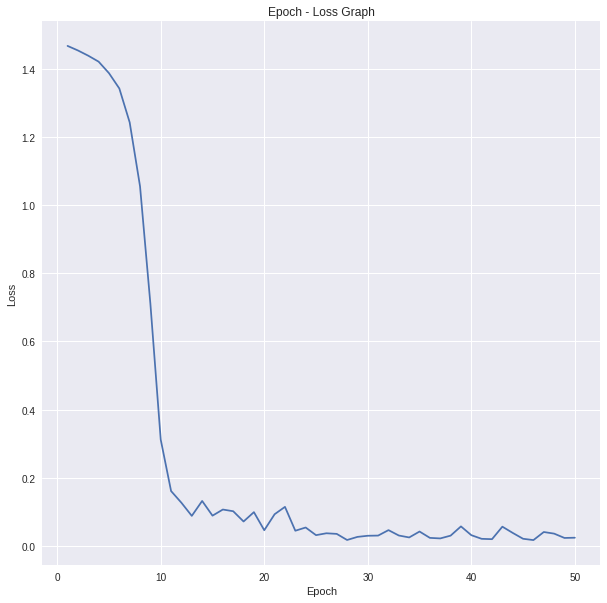

In [0]:
fig = plt.figure(figsize=(10,10))
plt.plot(np.arange(1, len(losses) + 1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch - Loss Graph")
plt.show()

# Testing the Model
**Test the Model and Print Accuracy**

In [0]:
test_data = load_data(TEST_DIR)
# Test Model
correct = 0
total = 0
with torch.no_grad():
    for data in test_data:
        images, labels = data
        outputs = model(images) # get the output from model
        _, predicted = torch.max(outputs.data, 1) # take the max as result
        total += labels.size(0)
        correct += (predicted == labels).sum().item() 

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 100 %


**Functions to Display Examples**

In [0]:
test_transforms = transforms.Compose([transforms.Resize(IMG_SIZE), transforms.ToTensor(), ])

def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    
    return index


def get_random_images(num):
    data = datasets.ImageFolder(TEST_DIR, transform=test_transforms)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()

    return images, labels

**Display Test Results**

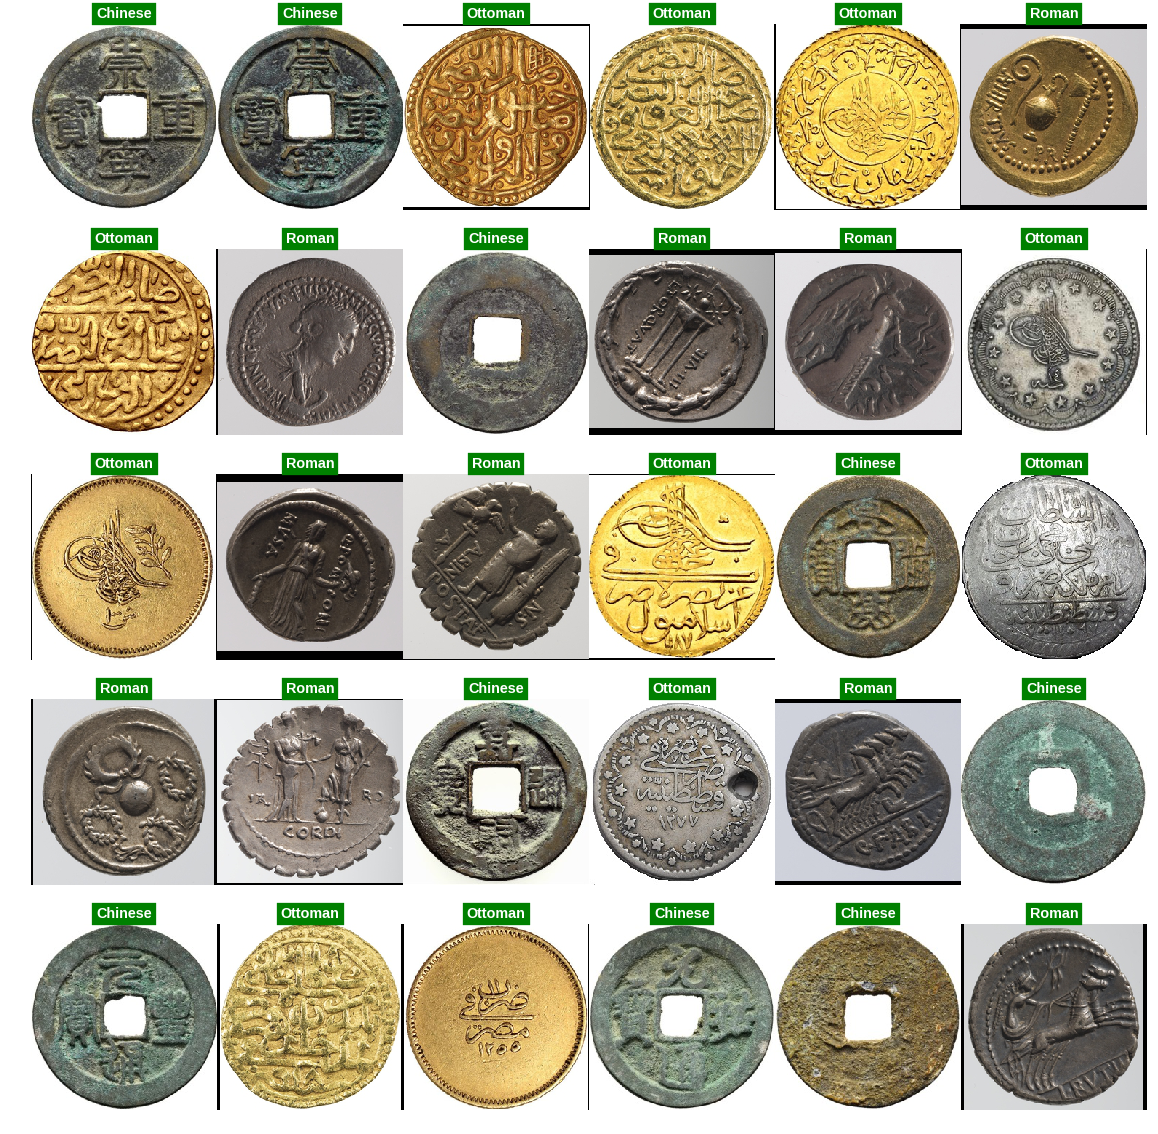

In [0]:
classes = ["Chinese", "Ottoman", "Roman"]
to_pil = transforms.ToPILImage()
images, labels = get_random_images(30) # There are 30 test images
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(wspace=0, hspace=0.2)

for i in range(len(images)):
    image = to_pil(images[i])
    label_index = predict_image(image)
    sub = fig.add_subplot(5, 6, i+1)
    res = int(labels[i]) == label_index  # Prediction result
    bgc = "g" if res else "r"
    sub.set_title(str(classes[label_index]), fontsize="large",fontweight="bold",
                  color="white", backgroundcolor=bgc)
    plt.axis('off')
    plt.imshow(image)

plt.show()
